In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spotify-playlists/spotify_dataset.csv
/kaggle/input/spotify-playlists/README.txt


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Data

In [3]:
df_playlist = pd.read_csv('/kaggle/input/spotify-playlists/spotify_dataset.csv', error_bad_lines=False, warn_bad_lines=False)
df_playlist.head()

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010


In [4]:
df_playlist.shape

(12891680, 4)

In [5]:
# clean up column names
df_playlist.columns = df_playlist.columns.str.replace('"', '')
df_playlist.columns = df_playlist.columns.str.replace('name', '')
df_playlist.columns = df_playlist.columns.str.replace(' ', '')
df_playlist.columns

Index(['user_id', 'artist', 'track', 'playlist'], dtype='object')

### Summary Statistics

In [6]:
df_playlist.describe()

,user_id,artist,track,playlist
count,12891680,12858112,12891595,12890434
unique,15918,289821,2032044,157504
top,4398de6902abde3351347b048fcdc287,Daft Punk,Intro,Starred
freq,295275,36086,6676,1337085


### Missing values

In [7]:
# is there any missing values?
df_playlist.isnull().values.any()

True

In [8]:
# count of missing values by column
df_playlist.isnull().sum()

user_id         0
artist      33568
track          85
playlist     1246
dtype: int64

### Duplicates

In [9]:
df_playlist[df_playlist.duplicated()]

,user_id,artist,track,playlist
5705048,03cc97c2091c06037a465550362e7187,Taverner Consort & Players,"L'Orfeo, Act I: Balletto – Lasciate i monti""""",Monteverdi: L'Orfeo
10657566,b5bf31e2004ab721056cd28e613a4c64,Django Reinhardt,I Won't Dance,Django Reinhardt
12641328,383e2887b4e09bd7871ec3f312ec3a27,Chet Baker,You Don't Know What Love Is,Chet Baker


In [10]:
# drop duplicates
df_playlist = df_playlist.drop_duplicates(keep='first')

### Top frequent artists

In [11]:
df_playlist["artist"].value_counts().head(10)

Daft Punk             36086
Coldplay              35485
Radiohead             31429
The Rolling Stones    30832
Kanye West            29111
JAY Z                 28928
Eminem                28894
Queen                 28079
David Bowie           27802
Michael Jackson       26336
Name: artist, dtype: int64

### Top frequent tracks

In [12]:
df_playlist[["track", "artist"]].value_counts().head(10)

track                             artist                 
Midnight City                     M83                        2609
Get Lucky - Radio Edit            Daft Punk                  2341
Radioactive                       Imagine Dragons            2336
Little Talks                      Of Monsters and Men        2254
Wake Me Up                        Avicii                     2242
Royals                            Lorde                      2219
Ho Hey                            The Lumineers              2180
Can't Hold Us - feat. Ray Dalton  Macklemore & Ryan Lewis    2066
Pompeii                           Bastille                   2014
Blurred Lines                     Robin Thicke               1996
dtype: int64

### Plot playlist length (track count)

<AxesSubplot:>

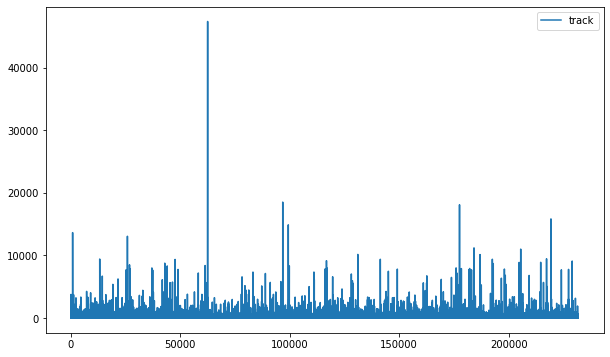

In [13]:
df_playlist.groupby(["user_id", "playlist"], as_index=False)['track'].nunique().plot(figsize=(10,6))

#### short read on playlist length on major platforms:
https://blog.chartmetric.com/the-optimal-playlist-length-for-the-top-playlists-on-each-streaming-platform/

In [14]:
avg_count = df_playlist.groupby(["user_id", "playlist"], as_index=False)['track'].nunique().mean().round()
print(f"The average track count per playlist is {avg_count[0]}")

The average track count per playlist is 56.0


### Longest playlists

In [15]:
df_playlist.groupby(["user_id", "playlist"], as_index=False)['track'].nunique().sort_values(by=['track'], ascending=False).head(10)

,user_id,playlist,track
62464,4398de6902abde3351347b048fcdc287,Starred,47362
96781,68756b4d60b6fac27789e85c2b63d1c6,Starred,18509
177563,c410ee930bd5f0e4893632503ec17b05,Starred,18082
219344,f2604a69836c94d00fcd11dd602944fc,everything,15824
99320,6b85a8076b4f3b1036ef15f09e2feeeb,Generos,14877
767,00dd7fde8040db835d917e077bb47e4b,Starred,13635
25809,1c43b609f0b4a55de35803000c86ade0,Starred,13053
184184,cba242053229db043497e4dd284b025f,Starred,11195
205528,e3833c156aef7b25ba9d8837341a99bb,All Live Files,11002
131089,8ece433d541d9fac7fbd7c0c6082c7a6,Musica!,10154


#### Let's filter out the Starred playlists:

In [16]:
df_playlist[df_playlist["playlist"]!='Starred'].groupby(["user_id", "playlist"], as_index=False)['track'].nunique().sort_values(by=['track'], ascending=False).head(10)

,user_id,playlist,track
214598,f2604a69836c94d00fcd11dd602944fc,everything,15824
97217,6b85a8076b4f3b1036ef15f09e2feeeb,Generos,14877
201045,e3833c156aef7b25ba9d8837341a99bb,All Live Files,11002
128287,8ece433d541d9fac7fbd7c0c6082c7a6,Musica!,10154
61114,4398de6902abde3351347b048fcdc287,Library & Streams (Part 3),9508
61119,4398de6902abde3351347b048fcdc287,Library & Streams (Part 8),9495
61117,4398de6902abde3351347b048fcdc287,Library & Streams (Part 6),9469
61098,4398de6902abde3351347b048fcdc287,Library & Streams (Part 12),9466
61118,4398de6902abde3351347b048fcdc287,Library & Streams (Part 7),9459
61115,4398de6902abde3351347b048fcdc287,Library & Streams (Part 4),9441


#### There is a 10,000-song cap for Spotify playlists, but there seems to be a few with more than 10,000 tracks...
#### There is no limit for libraries though! last year Spotify removed the limit:
https://community.spotify.com/t5/Live-Ideas/All-Platforms-Your-Library-Increase-maximum-Songs-allowed-in/idi-p/733759

### Plot user count per track

<AxesSubplot:>

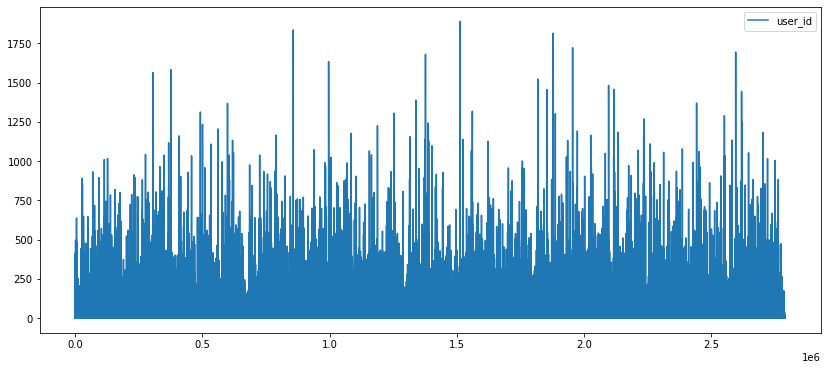

In [17]:
df_playlist.groupby(["track", "artist"], as_index=False)["user_id"].nunique().plot(figsize=(14,6))

In [18]:
# avg_count = df_playlist.groupby(["track", "artist"], as_index=False)["user_id"].nunique().mean().round()
# print(f"The average user count per track is {avg_count[0]}")

### Tracks with highest user count

In [19]:
df_playlist.groupby(["track", "artist"], as_index=False)["user_id"].nunique().sort_values(by=["user_id"], ascending=False).head(5)

,track,artist,user_id
1512803,Midnight City,M83,1890
857383,Get Lucky - Radio Edit,Daft Punk,1836
1877084,Radioactive,Imagine Dragons,1815
1955096,Royals,Lorde,1723
2595911,Wake Me Up,Avicii,1695


In [20]:
# you may have noticed that the user counts are different from the frequency counts. 
# this is because a user may add a track to more than one playlist
# here is an example:
df_playlist[(df_playlist["artist"]=="Bastille") & (df_playlist["track"]=="Pompeii") & (df_playlist["user_id"]=="650c4d63a819dbb77cc15a87f407039a")]

,user_id,artist,track,playlist
13839,650c4d63a819dbb77cc15a87f407039a,Bastille,Pompeii,City Life
13879,650c4d63a819dbb77cc15a87f407039a,Bastille,Pompeii,Corcovado
13914,650c4d63a819dbb77cc15a87f407039a,Bastille,Pompeii,D.I.Y
13956,650c4d63a819dbb77cc15a87f407039a,Bastille,Pompeii,Darkside
14033,650c4d63a819dbb77cc15a87f407039a,Bastille,Pompeii,Divided Self
14340,650c4d63a819dbb77cc15a87f407039a,Bastille,Pompeii,Ribbon
14382,650c4d63a819dbb77cc15a87f407039a,Bastille,Pompeii,Run Away
14420,650c4d63a819dbb77cc15a87f407039a,Bastille,Pompeii,Sister Winter
